
### A. Configurando o PySpark
> Código padrão para configuração no ambiente do Google Colab

In [1]:
# Instalando o Spark na máquina virtual do Colab
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!tar xf spark-3.1.2-bin-hadoop2.7.tgz

# Definindo a variável de ambiente do Java
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

# Definindo a variável de ambiente do Spark
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

# Configurando o findspark
!pip install -q findspark
import findspark
findspark.init()

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:7 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [48.6 kB]
Get:8 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,046 kB]
Get:9 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease [18.1 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,599 kB]
Hit:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,326 kB]
Hit:13 https://ppa.launchpadcontent.net/

### B. Inicializando a sessão do Spark e criando um DataFrame


> Uma SparkSession é um ponto de entrada para se utilizar as funções do SparkSQL, DataFrame e Dataset. Ela também contém as funções de um SparkContext, um ponto de entrada mais antigo que realiza operações mais "brutas" (de baixo nível).

In [3]:
# Importando os pacotes necessários para o Spark
from pyspark.sql import SparkSession
from pyspark import SparkFiles

# Importando outros pacotes necessários para o restante do código
import pandas as pd
import numpy as np
import urllib.request

# Inicializando a sessão do Spark
spark = SparkSession.builder.getOrCreate()



> Será criado um DataFrame com dados abertos de uma instituição bancária disponíveis no [Kaggle](https://www.kaggle.com/datasets/prakharrathi25/banking-dataset-marketing-targets?resource=download). Para isso, o arquivo CSV, enviado para o Google Drive, será salvo no diretório do Google Colab e, em seguida, lido pela sessão do Spark.



In [4]:
# Definindo a URL que contém o arquivo do Drive e baixando-o para o diretório do Colab
url='https://drive.google.com/file/d/1NvZEDnpcGXmhLQ9xIC3swTrSLKLtFkMD/view?usp=share_link'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
urllib.request.urlretrieve(url, "train.csv")

# Criando o Spark DataFrame a partir do CSV baixado
df = spark.read.option("delimiter", ";").csv('train.csv', header=True)

In [5]:
# Mostrando as primeiras linhas do DataFrame
df.show(5)

# Obtendo o número de partições
print('Número de partições: %d' %(df.rdd.getNumPartitions()))

+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|age|         job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
| 58|  management|married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|     261|       1|   -1|       0| unknown| no|
| 44|  technician| single|secondary|     no|     29|    yes|  no|unknown|  5|  may|     151|       1|   -1|       0| unknown| no|
| 33|entrepreneur|married|secondary|     no|      2|    yes| yes|unknown|  5|  may|      76|       1|   -1|       0| unknown| no|
| 47| blue-collar|married|  unknown|     no|   1506|    yes|  no|unknown|  5|  may|      92|       1|   -1|       0| unknown| no|
| 33|     unknown| single|  unknown|     no|      1|     no|  no|unknown|  5|  may|     19

### C. Manipulando e analisando os dados do DataFrame

In [6]:
# 01. Criando uma view da tabela na sessão do Spark
# Necessário para usar SQL na tabela, se ela ainda não estiver disponível na sessão
df.createOrReplaceTempView("bank_data")

# 02. Mostrando todas as tabelas disponíveis na sessão do Spark
print(spark.catalog.listTables())

[Table(name='bank_data', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]


In [7]:
# 03. Criando uma query em SQL para obter a média dos saldos por nível educacional
query = """
  select
    education,
    avg(balance) as avg_balance
  from bank_data
  group by 1
"""
results = spark.sql(query)
results.show()

+---------+------------------+
|education|       avg_balance|
+---------+------------------+
|  unknown|1526.7544426494346|
| tertiary|1758.4164348545223|
|secondary| 1154.880786139126|
|  primary|1250.9499343161583|
+---------+------------------+



In [8]:
# 04. Convertendo o Spark DataFrame em um Pandas DataFrame
pd_df = df.toPandas()

# Printando o DataFrame criado
print(pd_df)

      age           job   marital  education default balance housing loan  \
0      58    management   married   tertiary      no    2143     yes   no   
1      44    technician    single  secondary      no      29     yes   no   
2      33  entrepreneur   married  secondary      no       2     yes  yes   
3      47   blue-collar   married    unknown      no    1506     yes   no   
4      33       unknown    single    unknown      no       1      no   no   
...    ..           ...       ...        ...     ...     ...     ...  ...   
45206  51    technician   married   tertiary      no     825      no   no   
45207  71       retired  divorced    primary      no    1729      no   no   
45208  72       retired   married  secondary      no    5715      no   no   
45209  57   blue-collar   married  secondary      no     668      no   no   
45210  37  entrepreneur   married  secondary      no    2971      no   no   

         contact day month duration campaign pdays previous poutcome    y  

In [9]:
# 05. Alterando os tipos de dados das colunas
df = df.withColumn('age', df.age.cast('int'))
df = df.withColumn('balance', df.age.cast('float'))
df = df.withColumn('day', df.age.cast('int'))
df = df.withColumn('duration', df.age.cast('int'))
df = df.withColumn('campaign', df.age.cast('int'))
df = df.withColumn('pdays', df.age.cast('int'))
df = df.withColumn('previous', df.age.cast('int'))

df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: float (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



In [10]:
# 06. Adicionando e removendo uma coluna no Spark DataFrame
df2 = df
df2 = df2.withColumn('is_married', df2.marital=='married')
df2 = df2.withColumn('birth_year', 2023-df2.age)

# Adicionando uma coluna condicional
from pyspark.sql.functions import when, monotonically_increasing_id, udf
df2 = df2.withColumn('educacao',
                    when(df.education == 'primary', 'primeiro grau')
                    .when(df.education == 'secondary', 'segundo grau')
                    .when(df.education == 'tertiary', 'terceiro grau')
                    .otherwise('desconhecido'))

# Alternativa em SQL:
df2 = spark.sql("""
                select
                  *,
                  marital == 'married' as is_married,
                  2023 - age as birth_year,
                  case
                    when education == 'primary' then 'primeiro grau'
                    when education == 'secondary' then 'segundo grau'
                    when education == 'tertiary' then 'terceiro grau'
                    else 'desconhecido'
                  end as educacao
                from bank_data
""")

# Adicionando uma coluna com o número da linha
df2 = df2.withColumn('numero_linha', monotonically_increasing_id())

# Removendo a coluna birth_year
df2.drop(df2.birth_year)
df2.show()

+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+----------+----------+-------------+------------+
|age|         job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|is_married|birth_year|     educacao|numero_linha|
+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+----------+----------+-------------+------------+
| 58|  management| married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|     261|       1|   -1|       0| unknown| no|      true|    1965.0|terceiro grau|           0|
| 44|  technician|  single|secondary|     no|     29|    yes|  no|unknown|  5|  may|     151|       1|   -1|       0| unknown| no|     false|    1979.0| segundo grau|           1|
| 33|entrepreneur| married|secondary|     no|      2|    yes| yes|unknown|  5|  may|      76|       

In [11]:
# 06. Renomeando uma coluna no Spark DataFrame
df2 = df2.withColumnRenamed('job', 'career')

In [12]:
# 07. Filtrando um dataset
df3 = df.filter("default=='yes'")

# ou
df3 = df.filter(df.default == 'yes')

# ou
df3 = spark.sql("select * from bank_data where default=='yes'")

df3.show()

+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|age|         job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
| 42|entrepreneur|divorced| tertiary|    yes|      2|    yes|  no|unknown|  5|  may|     380|       1|   -1|       0| unknown| no|
| 55|    services|divorced|secondary|    yes|      1|    yes|  no|unknown|  5|  may|     208|       1|   -1|       0| unknown| no|
| 51|      admin.|  single|secondary|    yes|     -2|     no|  no|unknown|  5|  may|     402|       3|   -1|       0| unknown| no|
| 33|  technician| married|secondary|    yes|     72|    yes|  no|unknown|  6|  may|     623|       1|   -1|       0| unknown| no|
| 33| blue-collar|  single|secondary|    yes|    -60|     no|  no|unknown|  6|  may

In [13]:
# 08. Selecionando colunas do dataset
df4 = df.select("age", "job", "y")

# ou
df4 = df.select(df.age, df.job, df.y)

# ou
df4 = spark.sql("select age, job, y from bank_data")

df4.show()

+---+------------+---+
|age|         job|  y|
+---+------------+---+
| 58|  management| no|
| 44|  technician| no|
| 33|entrepreneur| no|
| 47| blue-collar| no|
| 33|     unknown| no|
| 35|  management| no|
| 28|  management| no|
| 42|entrepreneur| no|
| 58|     retired| no|
| 43|  technician| no|
| 41|      admin.| no|
| 29|      admin.| no|
| 53|  technician| no|
| 58|  technician| no|
| 57|    services| no|
| 51|     retired| no|
| 45|      admin.| no|
| 57| blue-collar| no|
| 60|     retired| no|
| 33|    services| no|
+---+------------+---+
only showing top 20 rows



In [14]:
# 09. Detectando os tipos de dados do DataFrame
print(df.printSchema())

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: float (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)

None


In [15]:
# 11. Calculando valores agregados
df11a = df.groupBy().sum("duration")  # Média das idades
df11b = df.groupBy().mean("duration")  # Média das idades
df11c = df.groupBy().max("duration")   # Idade máxima

# ou
df11a = spark.sql("select sum(duration) from bank_data")
df11b = spark.sql("select avg(duration) from bank_data")
df11c = spark.sql("select max(duration) from bank_data")

df11a.show()
df11b.show()
df11c.show()

+-----------------------------+
|sum(CAST(duration AS DOUBLE))|
+-----------------------------+
|                  1.1671811E7|
+-----------------------------+

+-----------------------------+
|avg(CAST(duration AS DOUBLE))|
+-----------------------------+
|            258.1630797814691|
+-----------------------------+

+-------------+
|max(duration)|
+-------------+
|          999|
+-------------+



In [16]:
# 12. Agrupando os dados por coluna(s)
df12a = df.groupBy("marital").count()           # contar por grupo
df12b = df.groupBy("marital").mean("balance")   # média por grupo

# ou
df12a = spark.sql("select marital, count(*) as n from bank_data group by 1")
df12b = spark.sql("select marital, avg(balance) as avg_marital from bank_data group by 1")

df12a.show()
df12b.show()

+--------+-----+
| marital|    n|
+--------+-----+
|divorced| 5207|
| married|27214|
|  single|12790|
+--------+-----+

+--------+------------------+
| marital|       avg_marital|
+--------+------------------+
|divorced|1178.8722873055501|
| married|1425.9255897699713|
|  single|1301.4976544175138|
+--------+------------------+



In [17]:
# 13. Fazendo joins
# Fazendo um join do "df" a tabela com valores da média de saldo por estado civil
df13 = df.join(df12b, on='marital', how='left')
df13.show()

# Para joins entre uma tabela muito grande e uma tabela pequena, pode-se
# utilizar o broadcast() para aumentar a performance.
# Ex. tabela_grande = df.join(broadcast(tabela_pequena, on='marital', how='left'))

from pyspark.sql.functions import broadcast
df13 = df.join(broadcast(df12b), on='marital', how='left')

+--------+---+------------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+------------------+
| marital|age|         job|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|       avg_marital|
+--------+---+------------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+------------------+
| married| 58|  management| tertiary|     no|   58.0|    yes|  no|unknown| 58|  may|      58|      58|   58|      58| unknown| no|1425.9255897699713|
|  single| 44|  technician|secondary|     no|   44.0|    yes|  no|unknown| 44|  may|      44|      44|   44|      44| unknown| no|1301.4976544175138|
| married| 33|entrepreneur|secondary|     no|   33.0|    yes| yes|unknown| 33|  may|      33|      33|   33|      33| unknown| no|1425.9255897699713|
| married| 47| blue-collar|  unknown|     no|   47.0|    yes|  no|unknown| 47|  may|      47|      4

In [18]:
# 14. Ordenando por idade
df14 = df.orderBy(df.age.asc())

# ou
df14 = spark.sql("select * from bank_data order by age asc")

df14.show()

+---+-------+-------+---------+-------+-------+-------+----+---------+---+-----+--------+--------+-----+--------+--------+---+
|age|    job|marital|education|default|balance|housing|loan|  contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+-------+-------+---------+-------+-------+-------+----+---------+---+-----+--------+--------+-----+--------+--------+---+
| 18|student| single|secondary|     no|    156|     no|  no| cellular|  4|  nov|     298|       2|   82|       4|   other| no|
| 18|student| single|secondary|     no|      5|     no|  no| cellular| 24|  aug|     143|       2|   -1|       0| unknown| no|
| 18|student| single|  unknown|     no|    108|     no|  no| cellular|  8|  sep|     169|       1|   -1|       0| unknown|yes|
| 18|student| single|  primary|     no|    608|     no|  no| cellular| 13|  nov|     210|       1|   93|       1| success|yes|
| 18|student| single|  unknown|     no|    108|     no|  no| cellular|  9|  feb|      92|       1|  183|       

In [19]:
# 15. Removendo duplicatas
df15 = df.select(df.marital, df.education)
df15 = df15.dropDuplicates()

# ou
df15 = spark.sql("select distinct marital, education from bank_data")

df15.show()

+--------+---------+
| marital|education|
+--------+---------+
|divorced|  unknown|
|divorced| tertiary|
| married|  primary|
| married| tertiary|
|  single| tertiary|
|  single|  primary|
|  single|secondary|
|divorced|  primary|
|divorced|secondary|
|  single|  unknown|
| married|  unknown|
| married|secondary|
+--------+---------+



In [20]:
# 16. Mostrar estatísticas sumarizadas das colunas
df16 = df.describe()
df16.show()

+-------+------------------+-------+--------+---------+-------+------------------+-------+-----+--------+------------------+-----+------------------+------------------+------------------+------------------+--------+-----+
|summary|               age|    job| marital|education|default|           balance|housing| loan| contact|               day|month|          duration|          campaign|             pdays|          previous|poutcome|    y|
+-------+------------------+-------+--------+---------+-------+------------------+-------+-----+--------+------------------+-----+------------------+------------------+------------------+------------------+--------+-----+
|  count|             45211|  45211|   45211|    45211|  45211|             45211|  45211|45211|   45211|             45211|45211|             45211|             45211|             45211|             45211|   45211|45211|
|   mean| 40.93621021432837|   null|    null|     null|   null| 40.93621021432837|   null| null|    null| 40.936

### D. Visualização de dados
Para criar visualizações simples, pode-se utilizar as funções de plotagem do Pandas, através da API do Spark. Maiores customizações podem ser feitas por meio de pacotes como matplotlib, seaborn e plotly

<Axes: title={'center': 'Distribuição de idade'}, ylabel='Frequency'>

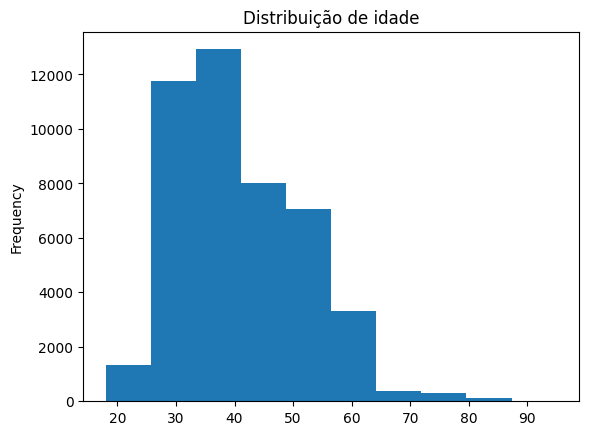

In [21]:
# Criando um PandasDataFrame com os valores de idade
idades = df.select("Age").toPandas()

# Plotando um histograma
idades['Age'].plot.hist(title = 'Distribuição de idade')

          count
marital        
divorced   5207
married   27214
single    12790


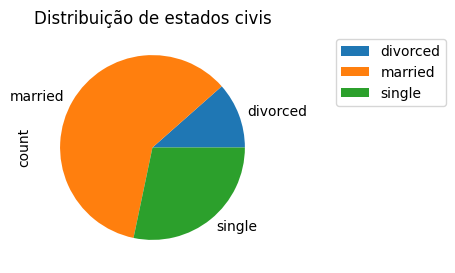

In [22]:
# Criando um DataFrame com a contagem para cada estado civil
df17 = df.groupBy(df.marital).count()
pandas_df17 = df17.toPandas().set_index('marital')
print(pandas_df17)

# Plotando em um gráfico de pizza
ax = pandas_df17.plot.pie(y='count', figsize=(15,3),
                          title= 'Distribuição de estados civis')
ax.legend(bbox_to_anchor=(1.8, 1.0))  # Setando a posição da legenda

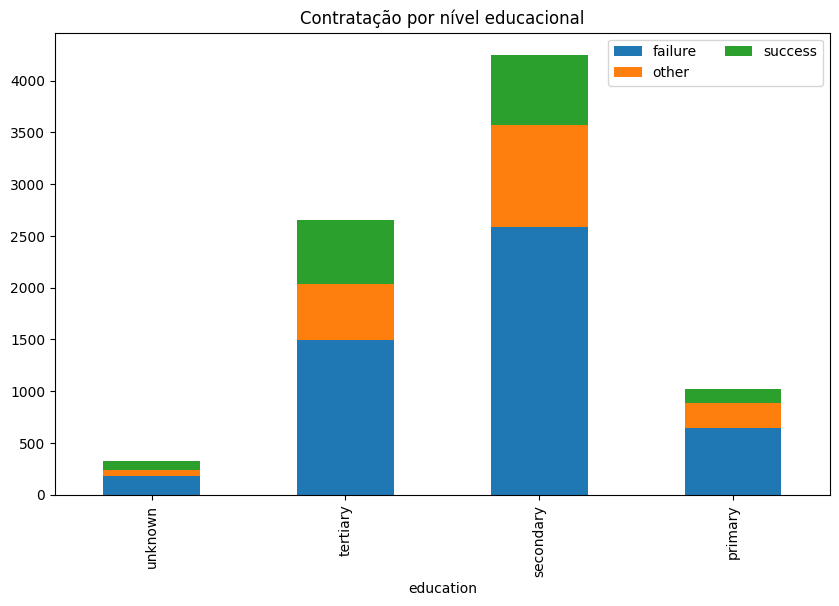

In [23]:
# Criando um gráfico de barras empilhadas para nível educacional e estado civil
df18 = df.groupBy(df.poutcome, df.education).count()             # Agrupando
df18 = df18.groupBy(df.education).pivot('poutcome').sum('count') # Pivotando
pandas_df18 = df18.toPandas().set_index('education')             # Transformando em Pandas
pandas_df18 = pandas_df18.drop(columns=['unknown'])              # Removendo unknowns
ax = pandas_df18.plot(kind='bar',
                      stacked=True,
                      figsize=(10, 6),
                      title='Contratação por nível educacional')# Plotando
ax.legend(bbox_to_anchor=(1.0, 1.0), ncol=2)                    # Adicionando legenda

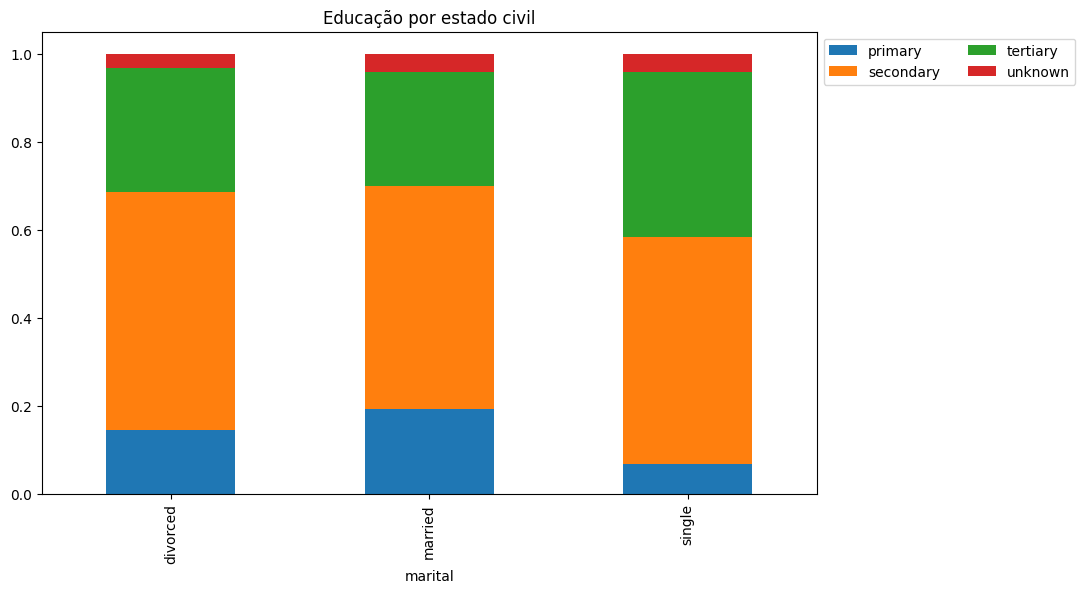

In [24]:
# Criando um gráfico de barras empilhadas em 100% para nível educacional e estado civil
df19 = df.groupBy(df.marital, df.education).count()             # Agrupando
df19 = df19.groupBy(df.marital).pivot('education').sum('count') # Pivotando
pandas_df19 = df19.toPandas().set_index('marital')              # Transformando em Pandas
pandas_df19 = pandas_df19.div(pandas_df19.sum(axis=1), axis=0)  # Calculando %
ax = pandas_df19.plot(kind='bar',
                      stacked=True,
                      figsize=(10, 6),
                      title='Educação por estado civil')        # Plotando
ax.legend(bbox_to_anchor=(1.0, 1.0), ncol=2)                    # Adicionando legenda